In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/Lung Disease Dataset"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"

In [ ]:
#  Preprocessing
img_size = 240
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 6054 images belonging to 5 classes.
Found 2016 images belonging to 5 classes.
Found 2025 images belonging to 5 classes.


In [ ]:
#  ResNet50 Model
input_tensor = Input(shape=(img_size, img_size, 3))#input layer 3 channels for RGB
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
out = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=out)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#  Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3)
]

In [ ]:
#  Train
start_time = time.time()
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)
end_time = time.time()
print("\nTotal Training Time: {:.2f} seconds".format(end_time - start_time))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 3348s 17s/step - accuracy: 0.7208 - loss: 0.6862 - val_accuracy: 0.2014 - val_loss: 4.9242 - learning_rate: 1.0000e-04
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 150s 791ms/step - accuracy: 0.8622 - loss: 0.3511 - val_accuracy: 0.2014 - val_loss: 7.3951 - learning_rate: 1.0000e-04
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 150s 788ms/step - accuracy: 0.8862 - loss: 0.2820 - val_accuracy: 0.2019 - val_loss: 5.4678 - learning_rate: 1.0000e-04
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 149s 781ms/step - accuracy: 0.9035 - loss: 0.2420 - val_accuracy: 0.3805 - val_loss: 2.6109 - learning_rate: 1.0000e-04
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 150s 788ms/step - accuracy: 0.9101 - loss: 0.2255 - val_accuracy: 0.5809 - val_loss: 1.1725 - learning_rate: 1.0000e-04
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 151s 794ms/step - accuracy: 0.9208 - loss: 0.1970 - val_accuracy: 0.8274 - val_loss: 0.3834 - learning_rate: 1.0000e-04
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
# ✅ Save model and training history
model.save("/content/drive/MyDrive/resnet50_lung_model.h5")
np.save("/content/drive/MyDrive/resnet50_history.npy", history.history)


In [ ]:
# ✅ Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 329ms/step - accuracy: 0.8721 - loss: 0.3410

Test Loss: 0.2501
Test Accuracy: 0.9116


In [ ]:
# Evaluate on test data
loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 0.8721 - loss: 0.3410

Test Loss: 0.2501
Test Accuracy: 0.9116


In [ ]:
# Generate predictions
predictions = model.predict(test_generator)
np.save("/content/drive/MyDrive/resnet50_preds.npy", predictions)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(predictions, axis=1)
true_labels = test_generator.classes
class_names = list(test_generator.class_indices.keys())
NUM_CLASSES = len(class_names)


64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 327ms/step


Classification Report:

                      precision    recall  f1-score   support

 Bacterial Pneumonia     0.8869    0.7395    0.8065       403
Corona Virus Disease     0.9878    0.9926    0.9902       407
              Normal     0.9194    0.9876    0.9523       404
        Tuberculosis     0.9975    0.9926    0.9951       408
     Viral Pneumonia     0.7727    0.8437    0.8066       403

            accuracy                         0.9116      2025
           macro avg     0.9129    0.9112    0.9101      2025
        weighted avg     0.9132    0.9116    0.9105      2025



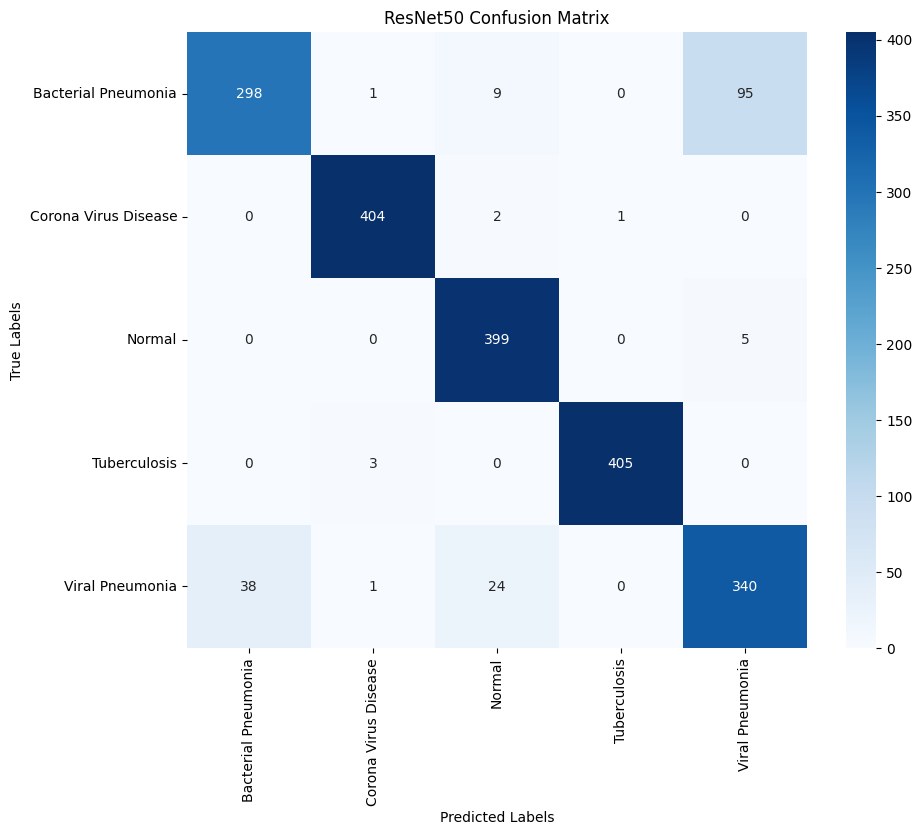

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification Report
print("Classification Report:\n")
print(classification_report(true_labels, y_pred_labels, target_names=class_names, digits=4))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('ResNet50 Confusion Matrix')
plt.show()


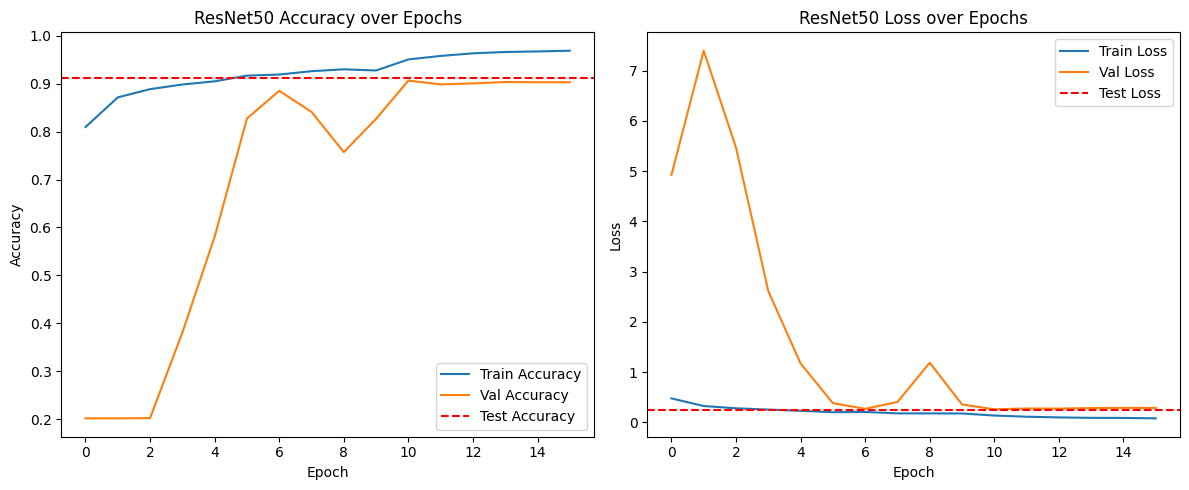

In [ ]:
# Updated Plot Accuracy and Loss (with Test)
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Val Accuracy')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.title('ResNet50 Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Train Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Val Loss')
plt.axhline(y=test_loss, color='red', linestyle='--', label='Test Loss')
plt.title('ResNet50 Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


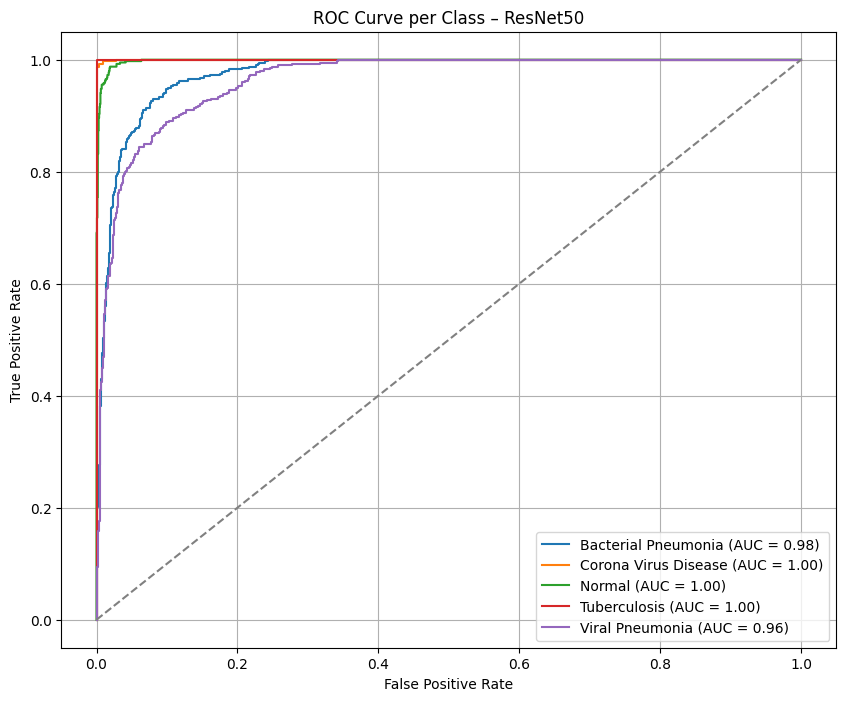

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# ROC Curve per class
y_true_bin = label_binarize(true_labels, classes=range(NUM_CLASSES))
plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Class – ResNet50')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 246, 246,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 120, 120,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 120, 120,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 120, 120,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 122, 122,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 60, 60,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 60, 60,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 60, 60,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 60, 60,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 60, 60,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 60, 60,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 60, 60,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 60, 60,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 60, 60,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 60, 60,    │      1,024 │ conv2_block1_3_c

 Total params: 71,445,649 (272.54 MB)

 Trainable params: 23,797,509 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 47,595,020 (181.56 MB)